## Actividad 1: Modelización y resolución con Dwave
Elisabeth Ortega Carrasco

**Enunciado**: en esta actividad construiremos un modelo capaz de resolver el problema del viajante. Para ello, debemos encontrar la ruta de mínima distancia que cumpla los siguientes requisitos:
* El inicio de la ruta y el final debe ser el nodo 0.
* La segunda ciudad que vamos a visitar (sin contar el origen) debe ser la 2.
* Todas las cuidades deben ser visitadas.
* Sólo podemos ir una vez a cada una de las ciudades.

**Resolución y explicación**:

In [19]:
# Invocamos las librerías necesarias
from neal import SimulatedAnnealingSampler # Sampler de D-Wave
from qubovert import boolean_var

import matplotlib.pyplot as plt # Librería de dibujo
import numpy as np # Libería de cálculo numérico
import networkx as nx # Librería de tratamiento de grafos

In [2]:
# Función para dibujar grafos (fuente: IBM)
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

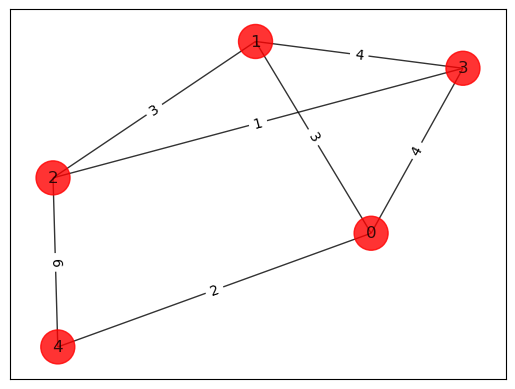

In [60]:
"""
Definimos la conectividad. Nos falta el parámetro entre 0 y 2 pero no es necesario, ya que según las
restricciones nunca iremos del nodo 0 al 2 directamente, así que no necesita peso aunque esté conectado.
"""

n = 5 # 5 nodos
G = nx.Graph() # Definimos un grafo G=(V,E)
G.add_nodes_from(np.arange(0, n, 1))
elist = [          # Añadimos los pesos para los nodos conectados
    (0, 1, 3), 
    (0, 3, 4), 
    (0, 4, 2), 
    (1, 2, 3),
    (1, 3, 4),
    (2, 3, 1),
    (2, 4, 6)
]

G.add_weighted_edges_from(elist) # Añadimos los pesos a las aristas

colors = ["r" for node in G.nodes()] # Coloreamos los nodos
pos = nx.spring_layout(G) # Funcionalidad para dibujar el grafo

draw_graph(G, colors, pos)

El mapa superior es en el que nos basaremos para resolver este problema. El grafo superior se trata de un ciclo Hamiltoniano tipo G=(V,E), en el que el origen y el final es el mismo nodo. 

Cada nodo lo representamos como $x_{i,p}$, siendo $i$ el número del nodo y $p$ el tiempo (también puede entenderse como el orden). La función a minimizar dependerá entonces de esos nodos, el peso de la arista que los conecta $w_{i,j}$, donde $i$ y $j$ son los nodos que conectan esa arista en concreto. Además se añade una penaliación para evitar contar con nodos no conectados entre ellos ($(i,j)\notin E$):

$$
\sum_{i,j\notin E}\sum_{p}x_{i,p}x_{j,p+1} > 0
$$

Así que la distancia a minimizar, sin más restricción que la anterior quedaría:

$$
D(x) = \sum_{i,j}w_{i,j} \sum_{p}x_{i,p}x_{j,p+1} 
$$


Introducimos las otras restricciones del enunciado:
* Cada nodo aparecerá una única vez en algun punto del grafo:

$$
\sum_{i}x_{i,p} = 1 \: \forall p
$$

* Cada nodo tiene que aparecer una vez:

$$
\sum_{p}x_{i,p} = 1 \: \forall i
$$


Estas dos asunciones tienen matices: el nodo 0 aparecerá dos veces (eso lo considera la misma definición de ciclo Hamiltoniano) y no se especifica que la segunda ciudad visitada sea la 2 (sin contar el origen):

$$
\sum_{i}x_{i,2} = 1
$$

Si agregamos todos las las restricciones, la función a minimizar queda de la siguiente manera:

$$
D(x) = \sum_{i,j}w_{i,j} \sum_{p}x_{i,p}x_{j,p+1} + \lambda \sum_{p}\big(1-\sum_{i}x_{i,p}\big)^{2} + \lambda \sum_{i}\big(1-\sum_{p}x_{i,p}\big)^{2} + \lambda \big(1-x_{i,2}\big)^{2}
$$

Agrupando las $\lambda$, nos queda:

$$
D(x) = \sum_{i,j}w_{i,j} \sum_{p}x_{i,p}x_{j,p+1} + \lambda \big(\sum_{p}\big(1-\sum_{i}x_{i,p}\big)^{2} + \sum_{i}\big(1-\sum_{p}x_{i,p}\big)^{2} + \big(1-x_{i,1}\big)^{2}\big)
$$

Lo que nos queda ahora es transformar estas ecuaciones en algo que entienda la computadora.


Para ejecutar un _SimulatedAnnealingSampler_ como una muestra de QUBO, debemos hacerle llegar un objeto "Q", que no es más que un diccionario que mapea el valor de cada arista con su peso (dict{(i,j): w_i,j}. Este diccionario puede obtenerse a partir de traducir a QUBO un modelo tipo _BinaryQuadraticModel_. Vamos a construir dicho modelo:

In [43]:
"""
Usamos las combinaciones de i y j que hemos usado para dibujar el grafo (variable elist).
Rellenaremos el vector con todas las opciones (nodos que conectan) y después eliminaremos las que incumplan alguna restricción.
"""
edges = [] # contiene las 3 variables: origen, destino y "orden"
x = {}

for i in range(n): # Añadimos las ciudades de origen
    for j in range(n): # Y las de destino:
        for p in range(n-1): # Hay una arista menos que el número de nodos (y empezamos a contar en 0...
            if G.has_edge(i,j):
                edges.append((i,j,p))

to_remove = [] # Definimos un 'cubo de la basura' para eliminar las ciudades no consideradas por las restricciones

"""
Ahora borramos aquellos caminos que no cumplan las restricciones
"""

for i, j, p in edges:
    if ((i != 0 and p == 0) or (i == 0 and p != 0)): # asegurando que la primera ciudad sea 0
        to_remove.append((i, j, p))
    elif ((j != 0 and p == (n-2)) or (j ==0 and p != (n-2))): # asegurando que la última ciudad sea 0
        to_remove.append((i,j,p))
    elif ((j == 2 and p != 1) or (j !=2 and p == 1)): # la segunda visita debe ser en la ciudad 2
        to_remove.append((i,j,p))
    elif ((i == 2 and p != 2) or ( i !=2 and p == 2)): # por lo tanto, la 3a ciudad debe salir de 2
        to_remove.append((i,j,p))

to_remove = list(set(to_remove)) # Borramos duplicados

edges_clean = [] # Aprovechamos para obtener una lista de aristas "visitables"

for e in edges:
    if (e not in to_remove):
        edges_clean.append(e)


"""
Rellenamos la variable booleana, añadiendo un 0 si
la combinacion i,j,p está en el vector "to_remove" o
1 si esa combinación está permitida (usamos QUBO)
"""
x = {} # Variable booleana

for e in edges:
    if (e not in to_remove):
        x[(e)] = 1
    else:
        x[(e)] = 0

"""
Ahora le damos el valor de si el vértice es transitable en ese orden,
creando las variables booleanas que necesitamos
(https://qubovert.readthedocs.io/en/latest/)
"""

for i,j,p in edges_clean:
    x[(i,j,p)] = boolean_var('x{}_{}_{}'.format(i,j,p))

In [52]:
"""
Construimos el modelo. Añadiremos las restricciones definidas de antemano.
"""
model = sum(x[(i, j, p)]*G[i][j]['weight'] for i,j,p in edges_clean)

lbda = 50 # Damos un valor de lambda más alto de lo que esperamos, pero sin pasarnos

"""
Añadimos las restricciones
"""
model.add_constraint_eq_zero(sum([x[i,j,p] for i,j,p in edges_clean if i == 0 and p == 0])-1, lam=lbda) # Partimos de la ciudad 0

model.add_constraint_eq_zero(sum([x[i,j,p] for i,j,p in edges_clean if j == 0 and p == 4])-1, lam=lbda) # Acabamos en la ciudad 5 (0) -> no podemos repetir labels
# AQUI ME QUEDO, TENGO Q AÑADIR EL NODO 5


TypeError: 'int' object is not iterable

In [6]:
# Llamamos al sampler y lo lanzamos
sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample_qubo(QUBO_def, num_reads = 10, chain_strenght = 10)

NameError: name 'QUBO_def' is not defined

In [ ]:
# Mostramos el resultado
print(sampleset)

In [ ]:
# Dibujamos el grafo con el camino marcado